# User Behavior Analysis and Prediction in Email Campaigns

## Introduction

This project aims to extract data-driven insights from an e-commerce market email campaign.

In [1]:
# import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

from sklearn.feature_selection import chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_curve,precision_score,recall_score,auc,precision_recall_curve
from sklearn.model_selection import train_test_split
import xgboost as xgb

## 1. Load Data

There are three datasets.

### 1.1 Email Sending Data

In [2]:
email_send = pd.read_csv("/home/ychen/Downloads/dataset/email_table.csv")

In [3]:
email_send.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [4]:
email_send.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


Totally we have 100k records.
- **email_id**: User or recipient's ID.
- **email_text**: Two versions of the emails: a long email with four paragraphs and a short email with two paragraphs.
- **email_version**: Personalized and generic versions. The personalized version begins with the user's name, while the generic version starts with "Hi."
- **hour**: The local time when users received these emails.
- **weekday**: The day of the week when the emails were received.
- **user_country**: The user's country, derived from their IP address.
- **user_past_purchases**: The count of past purchases by users who received the emails.

### 1.2 Email Open Data

In [5]:
email_open = pd.read_csv("/home/ychen/Downloads/dataset/email_opened_table.csv")
email_open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [6]:
email_open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


10,345 users open the email.

### 1.3 Link Clicked Data

In [7]:
email_link_click = pd.read_csv("/home/ychen/Downloads/dataset/link_clicked_table.csv")
email_link_click.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [8]:
email_link_click.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


Only 2119 users clicked the link more than once.

## 2. Preprocess & Clean Data


### 2.1 Preprocess
Here, we will convert data of type 'object' to 'integer' and then merge all three dataframes.

In [9]:
# Replace email_text with paragraphs. 
# Note that long email corresponds to 4 paragraphs, and short email corresponds to 2.
email_send["paragraphs"] = email_send['email_text'].apply(lambda x: 2 if x == 'short_email' else 4)
email_send.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,paragraphs
0,85120,short_email,personalized,2,Sunday,US,5,2
1,966622,long_email,personalized,12,Sunday,UK,2,4
2,777221,long_email,personalized,11,Wednesday,US,2,4
3,493711,short_email,generic,6,Monday,UK,1,2
4,106887,long_email,generic,14,Monday,US,6,4


In [10]:
# Replace email_version with personalized. 
# If it is personalized, then use "1", else "0".
email_send["personalized"] = email_send['email_version'].apply(lambda x: 1 if x == 'personalized' else 0)
email_send.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,paragraphs,personalized
0,85120,short_email,personalized,2,Sunday,US,5,2,1
1,966622,long_email,personalized,12,Sunday,UK,2,4,1
2,777221,long_email,personalized,11,Wednesday,US,2,4,1
3,493711,short_email,generic,6,Monday,UK,1,2,0
4,106887,long_email,generic,14,Monday,US,6,4,0


In [11]:
# Replace weekday with weekday_index. 
# Count starts from Monday.
weekday_index = {'Sunday':6,'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5}
# weekday_index = {'Sunday':7,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
email_send['weekday_index'] = email_send['weekday'].apply(lambda x: weekday_index[x])
email_send.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,paragraphs,personalized,weekday_index
0,85120,short_email,personalized,2,Sunday,US,5,2,1,6
1,966622,long_email,personalized,12,Sunday,UK,2,4,1,6
2,777221,long_email,personalized,11,Wednesday,US,2,4,1,2
3,493711,short_email,generic,6,Monday,UK,1,2,0,0
4,106887,long_email,generic,14,Monday,US,6,4,0,0


In [12]:
# Simplify column names
email_send.rename(columns={'user_past_purchases':'purchases','user_country':'country'},inplace=True)
email_send.head()

,email_id,email_text,email_version,hour,weekday,country,purchases,paragraphs,personalized,weekday_index
0,85120,short_email,personalized,2,Sunday,US,5,2,1,6
1,966622,long_email,personalized,12,Sunday,UK,2,4,1,6
2,777221,long_email,personalized,11,Wednesday,US,2,4,1,2
3,493711,short_email,generic,6,Monday,UK,1,2,0,0
4,106887,long_email,generic,14,Monday,US,6,4,0,0


In [13]:
# Merge with three dataframes
email_send['status'] = 'received'
email_send.loc[email_send['email_id'].isin(email_open['email_id']), 'status'] = 'opened'
email_send.loc[email_send['email_id'].isin(email_link_click['email_id']), 'status'] = 'clicked'
email_send.head()

,email_id,email_text,email_version,hour,weekday,country,purchases,paragraphs,personalized,weekday_index,status
0,85120,short_email,personalized,2,Sunday,US,5,2,1,6,received
1,966622,long_email,personalized,12,Sunday,UK,2,4,1,6,clicked
2,777221,long_email,personalized,11,Wednesday,US,2,4,1,2,received
3,493711,short_email,generic,6,Monday,UK,1,2,0,0,received
4,106887,long_email,generic,14,Monday,US,6,4,0,0,received


### 2.2 Clean Data

Note that the typical sequence is 'receiving email - opening email - clicking link'. However, some users may click links without opening the emails. For these users, we need to filter out those IDs and remove the records, as their actions are not a result of this marketing email campaign.

In [14]:
# Check IDs who opened emails without receiving ones (theoretically impossible)
ids_not_receive = email_open[~email_open['email_id'].isin(email_send['email_id'])]
print('{} users clicked the link via the other way.'.format(ids_not_receive.count()[0]))

0 users clicked the link via the other way.


Very good!

In [15]:
# Check IDs who clicked links without openning emails
ids_not_open = email_link_click[~email_link_click['email_id'].isin(email_open['email_id'])]
print('{} users clicked the link via the other way.'.format(ids_not_open.count()[0]))

50 users clicked the link via the other way.


In [16]:
# Remove these ids in the email dataframe
# Also remove nan
print('{} users in the original dataframe.'.format(len(email_send)))
email = email_send[~email_send['email_id'].isin(ids_not_open['email_id'])].copy()
email.dropna(inplace=True)
print('{} users in the new dataframe.'.format(len(email)))

100000 users in the original dataframe.
99950 users in the new dataframe.


In [17]:
# Check how many users receive, open, and click emails
email_response = email['status'].value_counts(normalize=True)
email_response

received    0.896498
opened      0.082801
clicked     0.020700
Name: status, dtype: float64

In [18]:
print ('{:.2f}% of users opened the email.'.format((1-email_response['received']) * 100))
print ('{:.2f}% of users clicked the link.'.format(email_response['clicked'] * 100))

10.35% of users opened the email.
2.07% of users clicked the link.


## 3. Data Exploration & Visualization

Now, let's explore and visualize the data to identify patterns.

### 3.1 Status vs Country

In [19]:
email_status_country = email.groupby(['country', 'status']).size().unstack(fill_value=0)
email_status_country

status,clicked,opened,received
country,,,
ES,80,310,9574
FR,74,332,9583
UK,481,1915,17532
US,1434,5719,52916


This email campaign predominantly targets users in the UK and US. Therefore, we need to calculate the normalized rates for each country. Since the 'opened' group is a subset of the 'received' group, and the 'clicked' group is a subset of the 'opened' group, normalization should be based on the 'received' group.

In [20]:
email_status_country_normalized = email_status_country.div(email_status_country['received'], axis=0)
email_status_country_normalized

status,clicked,opened,received
country,,,
ES,0.008356,0.032379,1.0
FR,0.007722,0.034645,1.0
UK,0.027436,0.109229,1.0
US,0.027100,0.108077,1.0


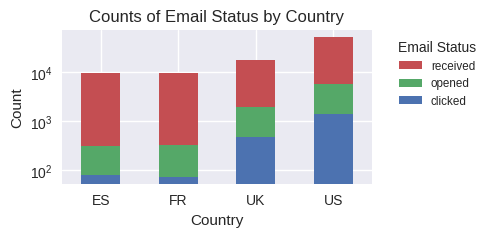

In [21]:
green_color = sns.color_palette()[1]
red_color = sns.color_palette()[2]

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
email_status_country['received'].plot(kind='bar', ax=ax, color=red_color)
email_status_country['opened'].plot(kind='bar', ax=ax, color=green_color)
email_status_country['clicked'].plot(kind='bar', ax=ax)
ax.set_title('Counts of Email Status by Country')
ax.set_xlabel('Country')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=0)
ax.legend(title="Email Status", fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Again we can use overlapped bars because (1) the 'opened' group is now a subset of the 'received' group, and (2) the 'clicked' group is a subset of the 'opened' group. Users in the UK and US appear to have higher open and click rates compared to those in Spain (ES) and France (FR). This discrepancy may be due to the emails being written in English, which could hinder engagement among non-English speaking users.

### 3.2 Status vs Weekday

In [22]:
email_status_weekday = email.groupby(['weekday', 'status']).size().unstack(fill_value=0)
email_status_weekday_normalized = email_status_weekday.div(email_status_weekday['received'], axis=0)
email_status_weekday_normalized

status,clicked,opened,received
weekday,,,
Friday,0.014260,0.065884,1.0
Monday,0.025530,0.105823,1.0
Saturday,0.019192,0.076917,1.0
Sunday,0.017387,0.078777,1.0
Thursday,0.027497,0.106890,1.0
Tuesday,0.027829,0.109225,1.0
Wednesday,0.030927,0.105862,1.0


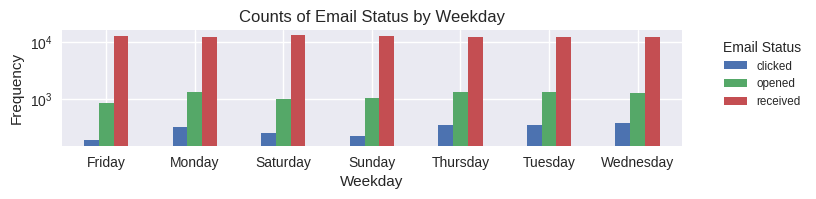

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 1.5))
email_status_weekday.plot(kind='bar', ax=ax)
ax.set_title('Counts of Email Status by Weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=0)
ax.legend(title="Email Status", fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Emails are sent to users almost equally across each weekday. The open rates are quite similar on business days, while the click rates are relatively lower on weekends. This could suggest that people prefer to check their emails on business days.

### 3.3 Status vs Personalized & Paragraphs

Since emails are sent to all users, we will now focus on analyzing the open and click rates only.

In [24]:
email_status_personalized = email.groupby(['email_version', 'status']).size().unstack(fill_value=0)
email_status_personalized = email_status_personalized.drop('received', axis=1)
email_status_personalized

status,clicked,opened
email_version,,
generic,729,3255
personalized,1340,5021


In [25]:
email_status_paragraphs = email.groupby(['email_text', 'status']).size().unstack(fill_value=0)
email_status_paragraphs = email_status_paragraphs.drop('received', axis=1)
email_status_paragraphs 

status,clicked,opened
email_text,,
long_email,904,3680
short_email,1165,4596


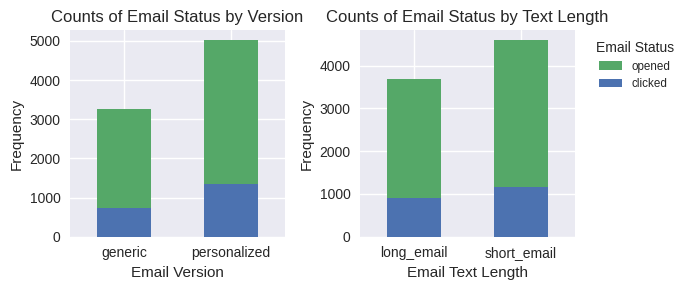

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
email_status_personalized['opened'].plot(kind='bar', ax=ax[0], color=green_color)
email_status_personalized['clicked'].plot(kind='bar', ax=ax[0])
ax[0].set_title('Counts of Email Status by Version')
ax[0].set_xlabel('Email Version')
ax[0].set_ylabel('Frequency')
ax[0].tick_params(axis='x', rotation=0)
ax[0].legend().set_visible(False)

email_status_paragraphs['opened'].plot(kind='bar', ax=ax[1], color=green_color)
email_status_paragraphs['clicked'].plot(kind='bar', ax=ax[1])
ax[1].set_title('Counts of Email Status by Text Length')
ax[1].set_xlabel('Email Text Length')
ax[1].set_ylabel('Frequency')
ax[1].tick_params(axis='x', rotation=0)
ax[1].legend(title="Email Status", fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

It appears that users who received personalized and short emails have higher open and click rates.

### 3.4 Status vs Sending Hours

In [27]:
email_status_hours = email.groupby(['hour', 'status']).size().unstack(fill_value=0)
email_status_hours = email_status_hours.drop('received', axis=1)
email_status_hours.head()

status,clicked,opened
hour,,
1,47,192
2,58,265
3,89,301
4,89,407
5,115,423


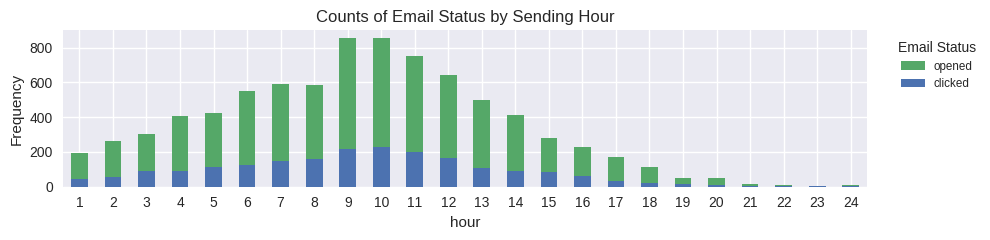

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
email_status_hours['opened'].plot(kind='bar', ax=ax, color=green_color)
email_status_hours['clicked'].plot(kind='bar', ax=ax)
ax.set_title('Counts of Email Status by Sending Hour')
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)
ax.legend(title="Email Status", fontsize='small', bbox_to_anchor=(1.025, 1), loc='upper left')

plt.tight_layout()
plt.show()

The sending hours also seem to affect the open and click rates.

### 3.5 Status vs Past Purchanse

In [29]:
email_status_purchase = email.groupby(['purchases', 'status']).size().unstack(fill_value=0)
email_status_purchase_normalized = email_status_purchase.div(email_status_purchase['received'], axis=0)

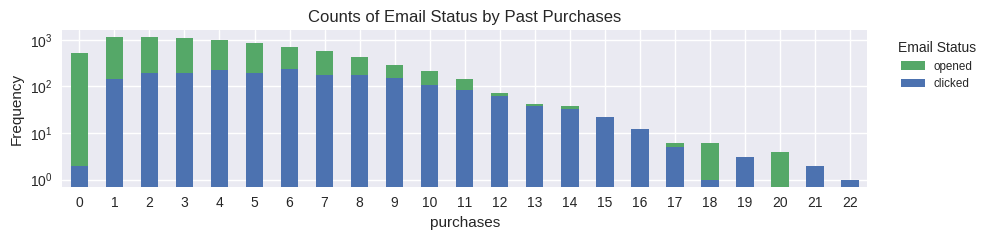

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2.5))
email_status_purchase['opened'].plot(kind='bar', ax=ax, color=green_color)
email_status_purchase['clicked'].plot(kind='bar', ax=ax)
ax.set_title('Counts of Email Status by Past Purchases')
ax.set_ylabel('Frequency')
ax.tick_params(axis='x', rotation=0)
ax.set_yscale('log')
ax.legend(title="Email Status", fontsize='small', bbox_to_anchor=(1.025, 1), loc='upper left')

plt.tight_layout()
plt.show()

The more past purchases a user has, the higher the click rate. Conversely, users with no previous purchases also exhibit higher open rates.

## 4. Prediction of Users Behavior

### 4.1 Prepare Data

First, we will encode several parameters and remove columns containing text.

In [31]:
email.head()

,email_id,email_text,email_version,hour,weekday,country,purchases,paragraphs,personalized,weekday_index,status
0,85120,short_email,personalized,2,Sunday,US,5,2,1,6,received
1,966622,long_email,personalized,12,Sunday,UK,2,4,1,6,clicked
2,777221,long_email,personalized,11,Wednesday,US,2,4,1,2,received
3,493711,short_email,generic,6,Monday,UK,1,2,0,0,received
4,106887,long_email,generic,14,Monday,US,6,4,0,0,received


In [32]:
# Encode parameters such as status and country
status_encoder = LabelEncoder()
country_encoder = LabelEncoder()
# Prepare X and y
email_scores = email.copy().set_index('email_id')
email_scores["country_index"] = country_encoder.fit_transform(email_scores.country)
email_response = status_encoder.fit_transform(email_scores.status)
# Drop texted columns and use email_id as index
email_scores.drop(['email_text','email_version','weekday','status','country'], axis=1, inplace=True)
features = ['hour','purchases','paragraphs','personalized','weekday_index','country_index']

In [33]:
chi2scores,_ = chi2(email_scores,email_response)
fscores,_ = f_classif(email_scores,email_response)
feat_scores = pd.DataFrame({'chi2scores':chi2scores,'fscores':fscores},index=features)
feat_scores.sort_values(by=['chi2scores','fscores'],ascending=[False,False])

,chi2scores,fscores
purchases,3531.192988,679.384928
country_index,379.511900,436.766620
personalized,322.342162,323.104071
weekday_index,287.387514,107.863475
hour,146.958215,33.794228
paragraphs,54.719521,82.364252


It turns out that users' past purchases, country, and whether the email was personalized are key factors affecting the response to the email campaign. Conversely, the day of the week, the hour the email was received, and the length of the email are less important.

### 4.2 XGBoost Model

In [34]:
X = email.copy()
# Create a weekend indicator
X['weekend'] = (email.weekday_index>=5).astype(int)
# One-Hot-Encode country
X = pd.get_dummies(X, columns=["country"],drop_first=True)
# Drop non-numerical columns
X.drop(['email_text','email_version','weekday','hour','status','weekday_index','status'], axis=1, inplace=True)
# Set email_id as index
X = X.set_index('email_id')
# Take a look
X.head()

,purchases,paragraphs,personalized,weekend,country_FR,country_UK,country_US
email_id,,,,,,,
85120,5,2,1,1,0,0,1
966622,2,4,1,1,0,1,0
777221,2,4,1,0,0,0,1
493711,1,2,0,0,0,1,0
106887,6,4,0,0,0,0,1


In [35]:
# Target is when the email link is clicked
y = (email.copy().set_index('email_id').status == 'clicked').astype(int)

In [36]:
# split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("The length of train set is {}, positive ratio={:.3f}.".format(X_train.shape[0],y_train.mean()))
print("The length of test set is {},  positive ratio={:.3f}.".format(X_test.shape[0],y_test.mean()))

The length of train set is 66966, positive ratio=0.020.
The length of test set is 32984,  positive ratio=0.022.


In [37]:
# Find the optimal set of parameters using cross validation
# Create DMatrix
train_matrix = xgb.DMatrix(X_train, y_train)
test_matrix = xgb.DMatrix(X_test)
# Set parameters for XGBoost
params = {'objective': 'binary:logistic','eval_metric': 'auc', 'max_depth': 6,
    'eta': 0.1,'subsample': 0.8,'colsample_bytree': 0.8}
cv_results = xgb.cv(params, train_matrix, num_boost_round=300, nfold=params.get('nfold', 5), 
                    metrics=params['eval_metric'], early_stopping_rounds=30, verbose_eval=10, seed=42)

[0]	train-auc:0.61960+0.00300	test-auc:0.61542+0.00474
[10]	train-auc:0.75485+0.00155	test-auc:0.73880+0.01219
[20]	train-auc:0.75978+0.00228	test-auc:0.74189+0.01195
[30]	train-auc:0.76202+0.00204	test-auc:0.74176+0.01163
[40]	train-auc:0.76360+0.00205	test-auc:0.74133+0.01140
[50]	train-auc:0.76538+0.00231	test-auc:0.74089+0.01147
[60]	train-auc:0.76673+0.00221	test-auc:0.74068+0.01056
[61]	train-auc:0.76677+0.00226	test-auc:0.74073+0.01066


In [38]:
# Find the best number of trees
n_best_trees = cv_results.shape[0]
print("The best number of trees: {}".format(n_best_trees))

The best number of trees: 32


In [39]:
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees, evals=watchlist, verbose_eval=10)

[0]	train-auc:0.61779
[10]	train-auc:0.75301
[20]	train-auc:0.75771
[30]	train-auc:0.75912
[31]	train-auc:0.75933


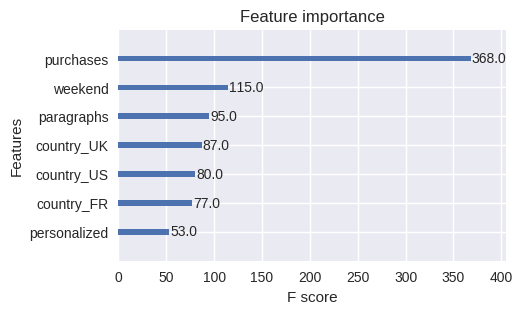

In [40]:
# Contributions of features
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
xgb.plot_importance(gbt, ax=ax)
plt.show()

In [41]:
# Validation
X_train_2,X_valid,y_train_2,y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
train_2_matrix = xgb.DMatrix(X_train_2,y_train_2)
valid_matrix = xgb.DMatrix(X_valid)
# Train model again
gbt_train_2 = xgb.train(params, train_2_matrix, n_best_trees)
# Predict on validation set
y_valid_pred = gbt_train_2.predict(valid_matrix)

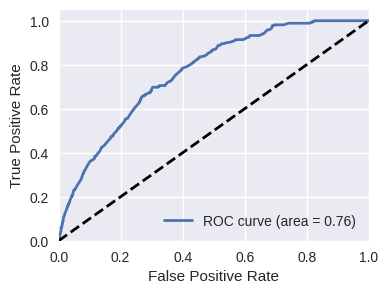

In [42]:
# Get ROC
fpr, tpr, thresholds = roc_curve(y_valid,y_valid_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Find a balance between precision and recall
idx = np.where((tpr > 0.6) & (fpr < 0.65))
idx_thres = thresholds[idx]
selected_thres = idx_thres[0] 
selected_thres

0.03142107

In [44]:
# Predict
y_pred_temp = gbt.predict(train_matrix)
y_train_pred = (y_pred_temp > selected_thres).astype(int)
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85     65633
           1       0.05      0.60      0.08      1333

    accuracy                           0.74     66966
   macro avg       0.52      0.67      0.47     66966
weighted avg       0.97      0.74      0.83     66966



In [45]:
y_pred_temp2 = gbt.predict(test_matrix)
y_test_pred = (y_pred_temp2 > selected_thres).astype(int)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85     32248
           1       0.05      0.56      0.09       736

    accuracy                           0.74     32984
   macro avg       0.52      0.65      0.47     32984
weighted avg       0.97      0.74      0.83     32984



In [46]:
print ("test precision: {:.2f}%".format(precision_score(y_test,y_test_pred) * 100))
print ("test recall: {:.2f}%".format(recall_score(y_test,y_test_pred) * 100))

test precision: 4.76%
test recall: 55.71%


In [47]:
n_emails_old_sent = y_test_pred.shape[0]
n_emails_new_sent = y_test_pred.sum()
saving_percentage = 100 - n_emails_new_sent * 100.0/n_emails_old_sent

print('# of emails sent in old way: {}.'.format(n_emails_old_sent))
print('# of emails sent in new way: {}.'.format(n_emails_new_sent))
print('saving percentage:           {}(%).'.format(round(saving_percentage,2)))

# of emails sent in old way: 32984.
# of emails sent in new way: 8607.
saving percentage:           73.91(%).


## Summary & Recommendation

We found that users in the UK and US exhibit higher open and click rates compared to those in Spain and France, likely due to the language barrier with emails written in English. Distribution of emails is nearly uniform across weekdays, with open rates remaining stable on business days and click rates dropping on weekends, suggesting a preference for checking emails during the workweek. Personalized and shorter emails have shown to elicit higher engagement. Key factors influencing campaign response include users' past purchases, country, and personalization of the email, whereas the timing and length of the email play lesser roles.

In the previous market campaign, 100,000 emails were sent, but only 2% of users clicked the link, resulting in a very low click-through rate (the number of users who clicked the link over the total number of recipients). To enhance efficiency, the company could use a predictive model to first forecast user behaviors and then target specific groups, potentially reducing costs by about 73%. Additionally, an A/B test could be conducted to evaluate the effectiveness of this approach. Users would be divided into two groups: a control group following the traditional method and a treatment group using the predictive model. The outcomes of the A/B test could then be assessed through hypothesis testing methods such as T-tests or Z-tests.